In [2]:
import re
import nltk
import textstat
import pandas as pd
import statsmodels.api as sm
from collections import Counter
from scipy.stats import mannwhitneyu

nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package wordnet to E:\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to E:\nltk_data...
[nltk_data]   Unzipping corpora\omw-1.4.zip.


True

In [22]:
df = pd.read_json("data/pandas.json", convert_dates=True).sort_values(by="closed_at")
contrib_cnt = Counter(df.resolver)
gfi, ngfi = df[df.resolver_commit_num <= 1], df[df.resolver_commit_num > 1]
print(gfi)
len(df), len(gfi), len(ngfi)

           owner    name  number     reporter                created_at  \
142   pandas-dev  pandas    1026     echlebek 2012-04-11 16:42:23+00:00   
75    pandas-dev  pandas     826         wesm 2012-02-24 20:18:45+00:00   
448   pandas-dev  pandas    1805      twiecki 2012-08-23 17:01:24+00:00   
482   pandas-dev  pandas    1897          erg 2012-09-11 19:23:24+00:00   
552   pandas-dev  pandas    2226  quintusdias 2012-11-11 19:42:34+00:00   
...          ...     ...     ...          ...                       ...   
7615  pandas-dev  pandas   46670       kwhkim 2022-04-06 17:13:10+00:00   
5687  pandas-dev  pandas   29528    abitrolly 2019-11-10 09:53:03+00:00   
5092  pandas-dev  pandas   25337       MarckK 2019-02-15 23:14:16+00:00   
7617  pandas-dev  pandas   46737        Yikun 2022-04-11 09:30:31+00:00   
7618  pandas-dev  pandas   46760   joseortiz3 2022-04-13 01:10:41+00:00   

                     closed_at        resolver  \
142  2012-05-07 18:02:34+00:00         kisielk   

(7619, 1622, 5997)

In [41]:
def count_code_snippets(s: str) -> int:
    p = re.compile(r"```.+?```", flags=re.S)
    if s is None:
        return 0
    return len(p.findall(s))


def delete_code_snippets(s: str) -> str:
    if s is None:
        return ""
    p = re.compile(r"```.+?```", flags=re.S)
    s = p.sub("", s)
    # return " ".join(s.split())
    return s


def count_urls(s: str) -> int:
    if s is None:
        return 0
    p = re.compile(r"http[:/\w\.]+")
    lst = list(
        filter(  # do not count images, this will be done in count_imgs()
            lambda s2: not (
                s2.endswith("jpg") or s2.endswith("jpeg") or s2.endswith("png")
            ),
            p.findall(s),
        )
    )
    return len(lst)


def delete_urls(s: str) -> str:
    if s == None:
        return ""
    p = re.compile(r"http[:/\w\.]+")
    s = p.sub("", s)
    # return " ".join(s.split())
    return s


def count_imgs(s: str) -> int:
    if s is None:
        return 0
    p = re.compile(r"http[:/\w\.]+")
    lst = list(
        filter(
            lambda s2: s2.endswith("jpg") or s2.endswith("jpeg") or s2.endswith("png"),
            p.findall(s),
        )
    )
    return len(lst)

def delete_imgs(s: str) -> str:
    if s is None:
        return ""
    p = re.compile(r"http[:/\w\.]+")
    filter(
        lambda s2: s2.endswith("jpg") or s2.endswith("jpeg") or s2.endswith("png"),
        p.findall(s),
    )
    
    s = p.sub("", s)
    # return " ".join(s.split())
    return s

def count_text_len(s: str) -> int:
    if s == None:
        return 0
    return len(s.split())


def get_categorized_labels(labels: list) -> dict:
    keyword_rules = {
        "bug": ["bug"],
        "feature": ["feature"],
        "test": ["test", "testing"],
        "build": ["ci", "build"],
        "doc": ["doc", "document", "documentation"],
        "coding": ["code", "coding", "program", "programming"],
        "enhance": ["enhance", "enhancement"],
        "gfi": [
            "easy",
            "starter",
            "newbie",
            "beginner",
            "starter",
            "minor",
            "novice",
            ("good", "first"),
            ("low", "fruit"),
            ("effort", "low"),
            ("first", "time"),
            ("first", "timer"),
            ("first", "pr"),
            ("up", "for", "grab"),
        ],
        "medium": ["medium", "intermediate"],
        "major": [
            "important",
            "major",
            "breaking",
            "difficult",
            "hard",
            "core",
            "serious",
            ("priority", "p1"),
            ("priority", "high"),
            ("priority", "critical"),
        ],
        "triaged": [
            "triaged",
            "triage",
            "progress",
            "haspr",
            "fixed",
            "wontfix",
            ("ha", "pr"),
            ("ha", "fix"),
        ],
        "untriaged": [
            "untriaged",
            ("need", "triage"),
            ("needed", "triage"),
            ("no", "triage"),
        ],
    }

    label_cat = Counter()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    for k in keyword_rules:
        label_cat[k] = 0
    for label in labels:
        words = re.compile(r"\w+").findall(label.lower().replace("_", " "))
        words = [lemmatizer.lemmatize(w) for w in words]
        for cat, rules in keyword_rules.items():
            match = 0
            for rule in rules:
                if isinstance(rule, (tuple, list)):
                    if all(word in words for word in rule):
                        match = 1
                elif rule in words:
                    match = 1
                elif any(rule in w for w in words):
                    match = 1
            label_cat[cat] += match
    return label_cat

def count_words(s):
    s = s.lower()
    lst = re.split('\<+|\>+|\|+|\'+|\d|\`+|\#+|\s+|\,+|\.+|\!+|\:+|\?+|\;+|\(+|\)+|\-+|\_+|\=+|\++|\“+|\、+|\/+|\{+|\}+|\”+|\：+|\。+|\“+|\[+|\]+|\【+|\】+|\—+|\%+|\"+',s)    
    diccount = {}
    cnt = 0
    for i in lst:
        if i == ' ' or i =='' or len(i)==1:
            continue
        cnt += 1
        if i not in diccount:
            diccount[i] = 1  # 第一遍字典为空 赋值相当于 i=1，i为words里的单词
            # print(diccount)
        else:
            diccount[i] += 1    
#     print(diccount)
#     print(cnt)
    for key in diccount:
        diccount[key] = round(100*diccount[key]/cnt,2)
    return diccount

In [71]:

gfi = gfi.drop_duplicates("resolver", keep="first")
gfi["clean_body"] = gfi.body.map(lambda s: delete_code_snippets(delete_code_snippets(s)))
gfi["clean_body1"] = gfi.clean_body.map(lambda s: delete_imgs(delete_urls(s)))
gfi["len_title"] = gfi.title.map(count_text_len)
gfi["len_body"] = gfi.clean_body.map(count_text_len)
gfi["n_code_snips"] = gfi.body.map(count_code_snippets)
gfi["n_urls"] = gfi.body.map(count_urls)
gfi["n_imgs"] = gfi.body.map(count_imgs)
gfi["coleman_liau_index"] = gfi.clean_body.map(textstat.coleman_liau_index)
gfi["flesch_reading_ease"] = gfi.clean_body.map(textstat.flesch_reading_ease)
gfi["flesch_kincaid_grade"] = gfi.clean_body.map(textstat.flesch_kincaid_grade)
gfi["automated_readability_index"] = gfi.clean_body.map(textstat.automated_readability_index)
gfi["n_comments"] = gfi.comments.map(len)
gfi["n_events"] = gfi.events.map(len)
gfi["label_categories"] = gfi.labels.map(get_categorized_labels)


otc_gfi = gfi[gfi.resolver.map(lambda r: contrib_cnt[r] == 1)]
notc_gfi = gfi[gfi.resolver.map(lambda r: contrib_cnt[r] > 1)]
len(otc_gfi), len(notc_gfi)

(894, 449)

In [43]:
metrics = [
    "len_title", "len_body", 
    #"n_code_snips", "n_urls", "n_imgs", 
    "coleman_liau_index", 
    #"flesch_reading_ease", "flesch_kincaid_grade", "automated_readability_index", 
    "n_comments", "n_events",
    "additions", "deletions", "changed_files"
]
otc_gfi[metrics].describe()

,len_title,len_body,coleman_liau_index,n_comments,n_events,additions,deletions,changed_files
count,894.000000,894.000000,894.000000,894.000000,894.000000,894.000000,894.000000,894.000000
mean,8.014541,132.934004,14.641588,4.712528,17.699105,48.021253,13.878076,3.376957
std,3.215794,124.287916,16.362245,4.990149,12.615960,132.381251,61.732796,5.334706
min,2.000000,0.000000,-22.210000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,6.000000,43.000000,9.960000,2.000000,10.000000,9.000000,1.000000,1.000000
50%,8.000000,102.500000,12.180000,3.000000,15.000000,21.000000,2.000000,3.000000
75%,10.000000,191.000000,15.352500,6.000000,22.000000,45.000000,8.000000,4.000000
max,28.000000,1630.000000,346.400000,61.000000,140.000000,2858.000000,1316.000000,85.000000


In [44]:
notc_gfi[metrics].describe()

,len_title,len_body,coleman_liau_index,n_comments,n_events,additions,deletions,changed_files
count,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000
mean,8.182628,126.563474,13.581670,4.563474,17.590200,74.247216,33.100223,3.714922
std,3.196337,101.613374,17.022839,5.009910,12.456227,206.005199,163.040793,4.000421
min,1.000000,0.000000,-33.810000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,6.000000,41.000000,9.600000,1.000000,9.000000,12.000000,1.000000,1.000000
50%,8.000000,108.000000,11.810000,3.000000,15.000000,24.000000,4.000000,3.000000
75%,10.000000,189.000000,14.030000,6.000000,22.000000,62.000000,17.000000,4.000000
max,21.000000,543.000000,296.800000,34.000000,89.000000,2991.000000,2874.000000,35.000000


In [45]:
for metric in metrics:
    print(f"{metric:30} {mannwhitneyu(notc_gfi[metric], otc_gfi[metric])}")

len_title                      MannwhitneyuResult(statistic=193243.0, pvalue=0.13174358637294042)
len_body                       MannwhitneyuResult(statistic=197727.5, pvalue=0.3286290183760387)
coleman_liau_index             MannwhitneyuResult(statistic=183658.0, pvalue=0.005510227135383632)
n_comments                     MannwhitneyuResult(statistic=192339.5, pvalue=0.10483621014028066)
n_events                       MannwhitneyuResult(statistic=197661.0, pvalue=0.3249360006343028)
additions                      MannwhitneyuResult(statistic=177831.0, pvalue=0.000322608208866359)
deletions                      MannwhitneyuResult(statistic=179544.0, pvalue=0.000737409161828747)
changed_files                  MannwhitneyuResult(statistic=185418.5, pvalue=0.00908900846362039)


In [46]:
list(map(
    lambda x: (x[0], x[1] / len(otc_gfi)), 
    sorted(Counter(sum(otc_gfi.labels, [])).items(), key=lambda x: -x[1])[0:20]
))

[('good first issue', 0.31543624161073824),
 ('Docs', 0.2796420581655481),
 ('Bug', 0.2695749440715884),
 ('Effort Low', 0.23937360178970918),
 ('Difficulty Novice', 0.1331096196868009),
 ('Reshaping', 0.0894854586129754),
 ('Needs Tests', 0.0738255033557047),
 ('Difficulty Intermediate', 0.07158836689038031),
 ('Error Reporting', 0.06935123042505593),
 ('Enhancement', 0.06599552572706935),
 ('Timeseries', 0.05704697986577181),
 ('Indexing', 0.05480984340044743),
 ('Groupby', 0.053691275167785234),
 ('Visualization', 0.0447427293064877),
 ('Regression', 0.039149888143176735),
 ('Dtypes', 0.039149888143176735),
 ('API Design', 0.039149888143176735),
 ('Effort Medium', 0.03803131991051454),
 ('MultiIndex', 0.03467561521252797),
 ('Testing', 0.03355704697986577)]

In [47]:
list(map(
    lambda x: (x[0], x[1] / len(notc_gfi)), 
    sorted(Counter(sum(notc_gfi.labels, [])).items(), key=lambda x: -x[1])[0:20]
))

[('Bug', 0.32516703786191536),
 ('good first issue', 0.3028953229398664),
 ('Effort Low', 0.23608017817371937),
 ('Docs', 0.18262806236080179),
 ('Difficulty Novice', 0.12694877505567928),
 ('Needs Tests', 0.111358574610245),
 ('Reshaping', 0.0957683741648107),
 ('Difficulty Intermediate', 0.0801781737193764),
 ('Groupby', 0.0645879732739421),
 ('Timeseries', 0.05790645879732739),
 ('Indexing', 0.053452115812917596),
 ('Error Reporting', 0.051224944320712694),
 ('MultiIndex', 0.04899777282850779),
 ('Enhancement', 0.04899777282850779),
 ('API Design', 0.042316258351893093),
 ('Effort Medium', 0.0400890868596882),
 ('Categorical', 0.0400890868596882),
 ('Dtypes', 0.0378619153674833),
 ('Numeric', 0.0378619153674833),
 ('Testing', 0.0378619153674833)]

In [48]:
counter = Counter()
for cat in otc_gfi.label_categories:
    counter.update(cat)
total = sum(counter.values())
for k, v in counter.items():
    counter[k] = v / total
counter

Counter()

In [49]:
counter = Counter()
for cat in notc_gfi.label_categories:
    counter.update(cat)
total = sum(counter.values())
for k, v in counter.items():
    counter[k] = v / total
counter

Counter()

In [50]:
y = gfi.resolver.map(lambda r: contrib_cnt[r] > 1)
X = gfi[metrics]
log_reg = sm.Logit(y, X).fit()
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.637311
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               resolver   No. Observations:                 1343
Model:                          Logit   Df Residuals:                     1335
Method:                           MLE   Df Model:                            7
Date:                Fri, 27 May 2022   Pseudo R-squ.:              -0.0001736
Time:                        20:20:47   Log-Likelihood:                -855.91
converged:                       True   LL-Null:                       -855.76
Covariance Type:            nonrobust   LLR p-value:                     1.000
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
len_title             -0.0239      0.014     -1.667      0.095      -0.052       0.004
len_body              -0.0008      0.001     -1.510      0.131      -0.002       0.000
coleman_liau_index    -0.0129      0.006     -2.320      0.020      -0.024      -0.002
n_comments            -0.0086      0.023     -0.377      0.706      -0.053       0.036
n_events              -0.0067      0.009     -0.769      0.442      -0.024       0.010
additions              0.0004      0.001      0.635      0.526      -0.001       0.002
deletions              0.0022      0.001      1.852      0.064      -0.000       0.004
changed_files         -0.0149      0.015     -1.011      0.312      -0.044       0.014
======================================================================================
"""

In [59]:
otc_gfi["body_words_cnt"]

142     [(a, 11.63), (index, 6.98), (with, 6.98), (dat...
75      [(randomly, 25.0), (get, 25.0), (this, 25.0), ...
448     [(not, 4.41), (the, 4.41), (files, 4.41), (git...
482     [(this, 16.67), (is, 16.67), (a, 16.67), (regr...
552     [(is, 10.34), (the, 10.34), (if, 6.9), (of, 6....
                              ...                        
7499    [(and, 4.46), (the, 3.71), (to, 2.97), (asv, 2...
7615    [(the, 8.14), (seriesgroupby, 5.81), (of, 3.49...
5092    [(the, 13.7), (in, 5.48), (to, 4.11), (code, 4...
7617    [(none, 15.87), (pandas, 3.17), (version, 2.12...
7618    [(none, 15.13), (pandas, 2.21), (the, 1.85), (...
Name: body_words_cnt, Length: 894, dtype: object

In [57]:
notc_gfi["body_words_cnt"]

581                                                    []
786     [(to, 10.0), (datetime, 5.0), (time, 5.0), (re...
874                                                    []
1038    [(are, 4.65), (but, 4.65), (they, 4.65), (for,...
1052    [(pandas, 9.09), (complex, 9.09), (number, 6.0...
                              ...                        
6565    [(none, 10.33), (pandas, 3.31), (x, 2.48), (de...
7553    [(the, 7.23), (is, 3.83), (this, 3.4), (pandas...
7127    [(none, 8.33), (pandas, 2.98), (x, 2.38), (fr,...
7601    [(the, 8.62), (version, 5.17), (documentation,...
7603    [(duplicate, 7.78), (labels, 7.78), (the, 4.44...
Name: body_words_cnt, Length: 449, dtype: object

[('none', 6.15), ('the', 3.5), ('pandas', 2.12), ('a', 1.76), ('to', 1.68), ('of', 1.4), ('in', 1.27), ('is', 1.21), ('i', 1.2), ('this', 1.05), ('python', 0.83), ('and', 0.76), ('that', 0.71), ('output', 0.69), ('x', 0.68), ('it', 0.66), ('versions', 0.66), ('for', 0.62), ('details', 0.61), ('not', 0.58), ('with', 0.57), ('if', 0.57), ('be', 0.57), ('os', 0.54), ('on', 0.52), ('code', 0.46), ('have', 0.45), ('as', 0.45), ('pd', 0.45), ('problem', 0.45), ('s', 0.44), ('html', 0.42), ('lib', 0.42), ('py', 0.41), ('example', 0.4), ('all', 0.4), ('expected', 0.39), ('c', 0.37), ('utf', 0.37), ('an', 0.35), ('dataframe', 0.35), ('numpy', 0.35), ('show', 0.35), ('description', 0.34), ('when', 0.33), ('en', 0.33), ('matplotlib', 0.32), ('but', 0.32), ('e', 0.32), ('xlsxwriter', 0.32), ('lxml', 0.32), ('installed', 0.31), ('should', 0.3), ('ipython', 0.29), ('commit', 0.29), ('version', 0.29), ('file', 0.29), ('release', 0.29), ('us', 0.29), ('index', 0.28), ('or', 0.28), ('pip', 0.28), ('cyt

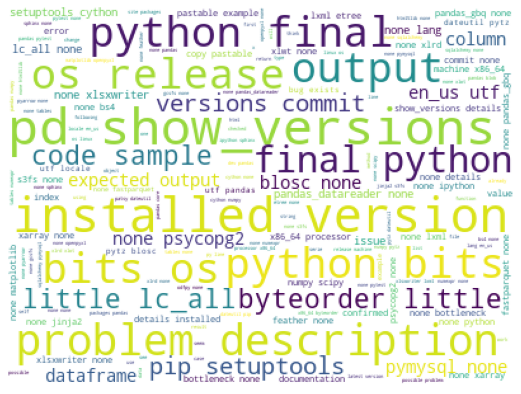

In [94]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_word_cloud(s):
    s = s.lower()
    wordcloud = WordCloud(background_color="white",\
                      width = 400,\
                      height = 300,\
                      max_font_size = 80,\
                      contour_width = 3,\
                      contour_color = 'steelblue'
                      ).generate(s)
    plt.figure(figsize=(13,7))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    
s1 = otc_gfi["clean_body1"].sum().lower()
# print(s1)

dic1 = count_words(s1)
dic1 = sorted(dic1.items(),key=lambda d:d[1],reverse=True)
print(dic1[0:100])

plot_word_cloud(s1)

[('none', 6.65), ('the', 3.34), ('pandas', 2.68), ('a', 1.7), ('to', 1.69), ('of', 1.44), ('is', 1.23), ('this', 1.1), ('i', 1.09), ('in', 1.08), ('output', 0.83), ('and', 0.78), ('python', 0.75), ('versions', 0.75), ('x', 0.71), ('it', 0.68), ('details', 0.64), ('py', 0.64), ('that', 0.62), ('os', 0.59), ('be', 0.58), ('for', 0.58), ('core', 0.57), ('if', 0.57), ('code', 0.55), ('with', 0.54), ('pd', 0.53), ('not', 0.52), ('on', 0.47), ('have', 0.45), ('example', 0.44), ('problem', 0.44), ('dev', 0.44), ('expected', 0.43), ('as', 0.42), ('all', 0.42), ('show', 0.41), ('master', 0.4), ('utf', 0.4), ('html', 0.39), ('s', 0.38), ('xlsxwriter', 0.36), ('lxml', 0.36), ('dataframe', 0.35), ('numpy', 0.34), ('en', 0.34), ('description', 0.34), ('series', 0.33), ('l', 0.33), ('blob', 0.33), ('should', 0.32), ('release', 0.32), ('sample', 0.32), ('but', 0.31), ('when', 0.31), ('matplotlib', 0.31), ('c', 0.31), ('us', 0.31), ('pytz', 0.31), ('commit', 0.31), ('cython', 0.31), ('scipy', 0.31), (

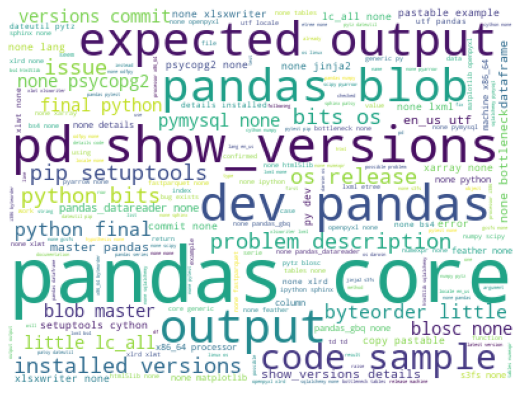

In [95]:
s2 = notc_gfi["clean_body1"].sum().lower()
dic2 = count_words(s2)
dic2 = sorted(dic2.items(),key=lambda d:d[1],reverse=True)
print(dic2[0:100])

plot_word_cloud(s2)